In [1]:
import SALib
from SALib.sample import saltelli
from SALib.analyze import sobol
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
#from tqdm import tqdm  # For progress bar
from ABM_Final_Final_Final import SocialNetwork

In [7]:
# We define our variables and bounds
problem = {
    'num_vars': 4,
    'names': ['prob', 'mu', 'temp', 'social'],
    'bounds': [[0., 1.], [0.01,1], [0.01,0.3], [0.,0.5]]
}

w_pop = 0.2
w_prox = 0.7
w_sim = 0.1

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 15
max_steps = 300
distinct_samples = 256

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)

# Initialize DataFrame to store results
num_samples = len(param_values) * replicates

data = pd.DataFrame(index=range(num_samples), columns=['prob', 'mu', 'temp', 'social'])

data['Run'], data['max IN degree'], data['avg clustering coeff'] = None, None, None

print(data)
# https://stackoverflow.com/questions/67750857/how-to-activate-conda-environment-in-vs-code


      prob   mu temp social   Run max IN degree avg clustering coeff
0      NaN  NaN  NaN    NaN  None          None                 None
1      NaN  NaN  NaN    NaN  None          None                 None
2      NaN  NaN  NaN    NaN  None          None                 None
3      NaN  NaN  NaN    NaN  None          None                 None
4      NaN  NaN  NaN    NaN  None          None                 None
...    ...  ...  ...    ...   ...           ...                  ...
23035  NaN  NaN  NaN    NaN  None          None                 None
23036  NaN  NaN  NaN    NaN  None          None                 None
23037  NaN  NaN  NaN    NaN  None          None                 None
23038  NaN  NaN  NaN    NaN  None          None                 None
23039  NaN  NaN  NaN    NaN  None          None                 None

[23040 rows x 7 columns]


C:\Users\tiefo\AppData\Local\Temp\ipykernel_20284\906095279.py:18: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, distinct_samples, calc_second_order=False)


In [8]:
# Define your model
def run_model(count, params,max_steps):
    n_agents = 75
    prob, temp, mu, social = params
    model = SocialNetwork(n_agents, prob, w_pop, w_prox, w_sim, mu, temp, social)
    for k in range(max_steps + 1):
        model.step()
        print(f"\rProgress: {(k / max_steps) * 100:.2f}%", end='', flush=True)
   
    df_results = pd.DataFrame(model.Data_Collector)
    
    return count, params,  df_results['avg clustering coeff'].iloc[-1], df_results['max IN degrees'].iloc[-1]

In [9]:
n_jobs = -1
count = 0

# Prepare a list to collect results
results = []

for i in range(replicates):
    with Parallel(n_jobs=n_jobs) as parallel:
        # Add progress bar
        parallel_results = parallel(
            delayed(run_model)(count + idx, vals, max_steps) 
            for idx, vals in enumerate(tqdm(param_values, desc=f"Replicate {i+1}/{replicates}"))
        )
    # Collect results
    results.extend(parallel_results)
    count += len(param_values)

# Save results to DataFrame

    #data.loc[run_id] = vals + [run_id, clustering_coeff, max_in]

# Save DataFrame to CSV
#data.to_csv(f"sobol_rep{replicates}_maxstep{max_steps}_distsamples{distinct_samples}.csv", index=False)


Replicate 15/15: 100%|██████████| 1536/1536 [54:34<00:00,  2.13s/it]


In [16]:
for result in results:
    count = result[0]
    vals = list(result[1])
    clustering_coeff = result[2]
    max_in = result[3]
    data.at[count, "prob"] = vals[0]
    data.at[count, "mu"] = vals[1]
    data.at[count, "temp"] = vals[2]
    data.at[count, "social"] = vals[3]
    data.iloc[count, len(vals):len(vals)+3] = count,max_in,clustering_coeff

print(data)

# Save DataFrame to CSV
data.to_csv(f"sobol_rep{replicates}_maxstep{max_steps}_distsamples{distinct_samples}.csv", index=False)

           prob        mu      temp    social    Run max IN degree  \
0      0.005859  0.503066  0.206543  0.147461      0             0   
1      0.779297  0.503066  0.206543  0.147461      1            59   
2      0.005859  0.116348  0.206543  0.147461      2             0   
3      0.005859  0.503066  0.115918  0.147461      3             0   
4      0.005859  0.503066  0.206543  0.178711      4             0   
...         ...       ...       ...       ...    ...           ...   
23035  0.353516  0.506934  0.128379  0.422852  23035            43   
23036  0.001953  0.878184  0.128379  0.422852  23036             0   
23037  0.001953  0.506934  0.225801  0.422852  23037             1   
23038  0.001953  0.506934  0.128379  0.231445  23038             0   
23039  0.353516  0.878184  0.225801  0.231445  23039            53   

      avg clustering coeff  
0                      0.0  
1                 0.282565  
2                      0.0  
3                      0.0  
4             

In [18]:
# Si_cluster = sobol.analyze(problem, data['avg clustering coeff'].values, calc_second_order=False, print_to_console=True)
# Si_IN_Degree = sobol.analyze(problem, data['max IN degree'].values, calc_second_order=False, print_to_console=True)
max(data['max IN degree'])

74

In [22]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

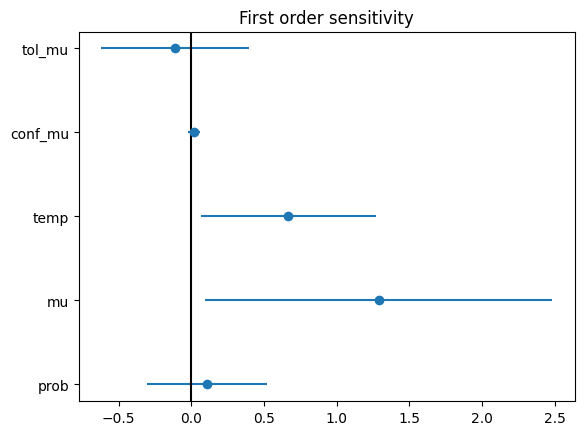

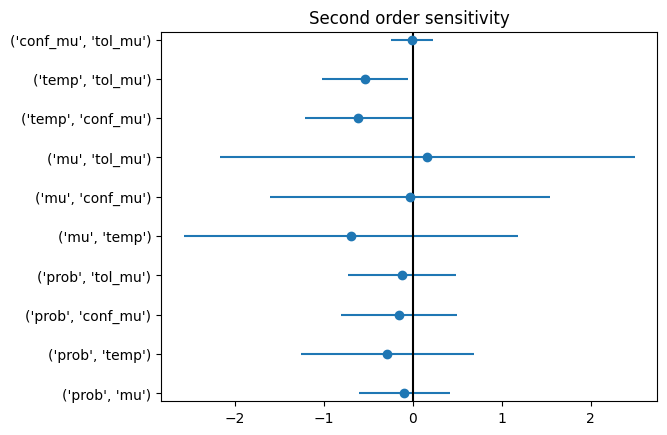

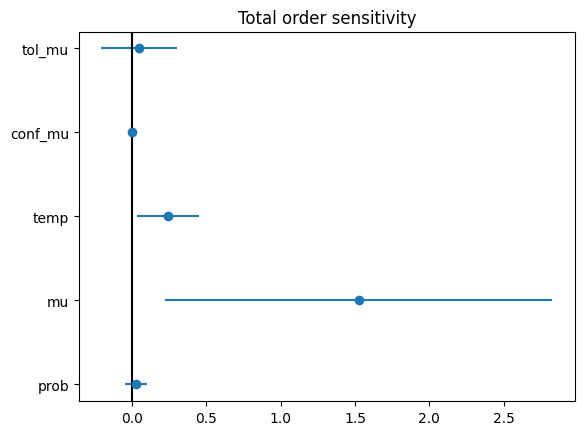

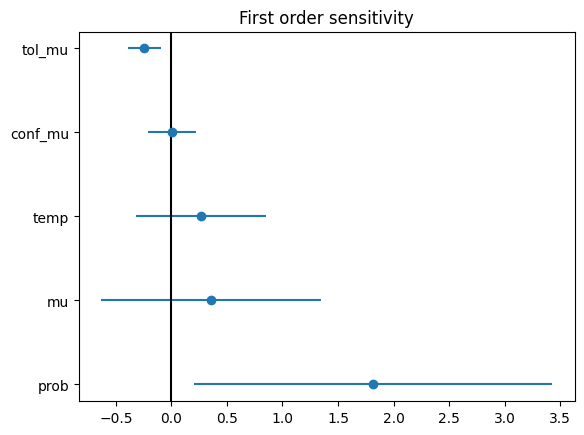

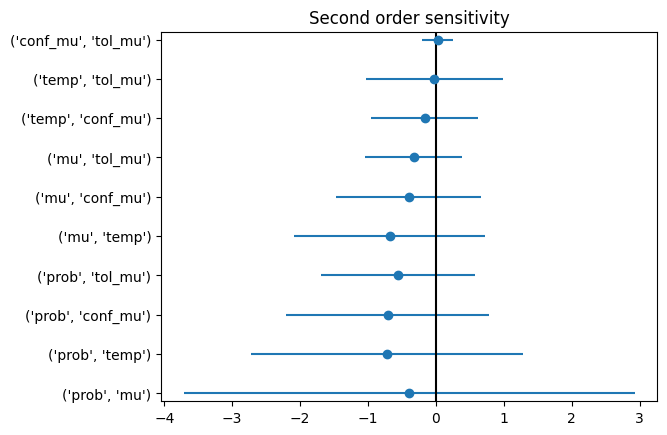

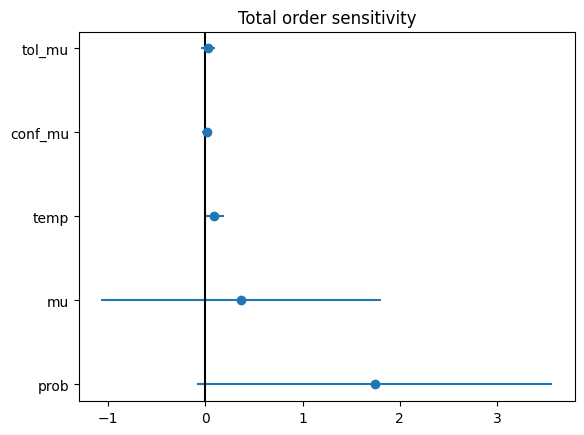

In [23]:
for Si in (Si_cluster, Si_IN_Degree):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Second order
    plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()